In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [12]:
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "class.csv")
# data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "class_mays.csv")
# data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "class_mays2.csv")
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "class_loc.csv")

In [13]:
df = pd.read_csv(data_path)

In [15]:
df = df[['Scheduled Setup Start', 'Scheduled Cleanup Complete', 'Room', 'Location', 'Primary Surgeon ID', 'Primary Service','Primary Procedure CPT Code']]
# df = df[['Scheduled Setup Start', 'Scheduled Cleanup Complete', 'Room', 'Location', 'Primary Surgeon Name', 'Primary Service','Primary Procedure CPT Code']]
df['Scheduled Setup Start']=pd.to_datetime(df['Scheduled Setup Start'])
df['Scheduled Cleanup Complete']=pd.to_datetime(df['Scheduled Cleanup Complete'])
df['Scheduled Room Duration']=(df['Scheduled Cleanup Complete']-df['Scheduled Setup Start']).astype('timedelta64[m]')
# df['test']=1
df = df.dropna()
df['Primary Procedure CPT Code']=df['Primary Procedure CPT Code'].str.replace('\D+','').astype(int)

df = df[df['Room'].str.contains(r'\d', regex=True)]
df = df[df['Location']=='MAIN OR']
# df = df[df['Location']=='MAYS OR']
df['Room']=df.apply(lambda row: int(re.search(r'\d+', row['Room']).group()), axis = 1)
df = df.loc[df['Room']<41]

# df['SurgeonID'] = df.groupby('Primary Surgeon ID').ngroup()
df=df.assign(CaseID=range(len(df)))

C:\Users\lliu10\AppData\Local\Temp\ipykernel_13832\1845173543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scheduled Setup Start']=pd.to_datetime(df['Scheduled Setup Start'])
C:\Users\lliu10\AppData\Local\Temp\ipykernel_13832\1845173543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scheduled Cleanup Complete']=pd.to_datetime(df['Scheduled Cleanup Complete'])
C:\Users\lliu10\AppData\Local\Temp\ipykernel_13832\1845173543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [5]:
X = df[['Primary Surgeon Name', 'Primary Service', 'Scheduled Room Duration', 'Primary Procedure CPT Code']]
# X = df[['Primary Surgeon ID', 'Scheduled Room Duration']]
# X = df[['Primary Service', 'test']]
# X = df[['Primary Surgeon Name', 'test']]
# X = np.array(df['Scheduled Room Duration'])
# X = np.array(df['Primary Procedure CPT Code'])
# X=X.reshape(-1, 1)

In [6]:
X['Primary Procedure CPT Code'][0]

36561

In [7]:
y = df['Room']
# y = df['Location']

In [8]:
features_to_encode = ['Primary Surgeon Name', 'Primary Service']
# features_to_encode = ['Primary Service']
# features_to_encode = ['Primary Surgeon Name']

In [9]:
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [10]:
seed=1
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto')

In [11]:
pipe = make_pipeline(col_trans, rf_classifier)
# pipe.fit(X_train, y_train)
pipe.fit(X, y)
# rf_classifier.fit(X,y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Primary Surgeon Name',
                                                   'Primary Service'])],
                                   verbose=False)),
                ('ran...
                 RandomForestClassifie

In [20]:
cross_val_score(rf_classifier, X, y, cv=10)

array([0.35294118, 0.36541889, 0.37344029, 0.38770053, 0.39393939,
       0.40106952, 0.38770053, 0.36987522, 0.36185383, 0.3264942 ])

In [12]:
y_pred = pipe.predict(X)
# y_pred = rf_classifier.predict(X)
accuracy_score(y, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y,y_pred),3)*100} %")

The accuracy of the model is 55.7 %


In [15]:
y_prob = pipe.predict_proba(X)

In [21]:
y_pred

array([2, 5, 5, ..., 6, 2, 5], dtype=int64)

In [22]:
y_prob

array([[0.03567827, 0.86465482, 0.02856054, 0.01966935, 0.01892028,
        0.03251675],
       [0.14502317, 0.04368751, 0.12052574, 0.11261017, 0.46162324,
        0.11653018],
       [0.14462215, 0.04370405, 0.1204555 , 0.11256653, 0.46206692,
        0.11658485],
       ...,
       [0.19829842, 0.0943066 , 0.17186945, 0.05998693, 0.06236563,
        0.41317297],
       [0.03567827, 0.86272968, 0.02856054, 0.01966935, 0.02084542,
        0.03251675],
       [0.14438738, 0.04499578, 0.09475421, 0.10253068, 0.49864265,
        0.11468929]])

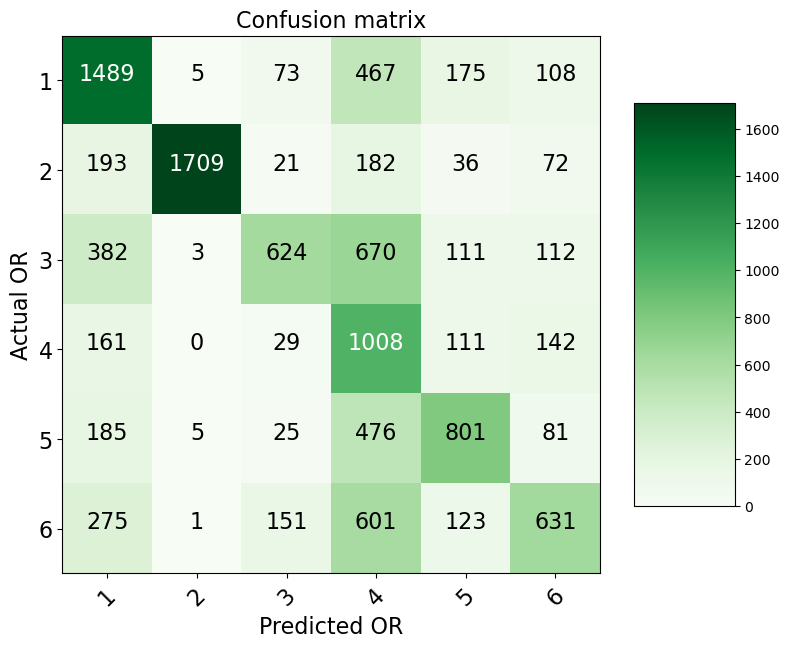

In [66]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 16)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 16)
    plt.yticks(tick_marks, classes, size = 16)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 16, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('Actual OR', size = 16)
        plt.xlabel('Predicted OR', size = 16)

# Let's plot it out
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes = [str(i) for i in range(1,7)])

In [67]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

[2.83529611e-03 6.99536915e-04 3.13435463e-04 1.21567459e-03
 0.00000000e+00 8.75034953e-04 0.00000000e+00 0.00000000e+00
 1.45819508e-01 0.00000000e+00 0.00000000e+00 9.14726002e-05
 0.00000000e+00 0.00000000e+00 6.68296895e-04 4.26096650e-04
 0.00000000e+00 0.00000000e+00 3.06745398e-04 0.00000000e+00
 0.00000000e+00 1.23685671e-03 5.37177992e-04 2.43739614e-03
 1.18187735e-03 2.63643331e-02 0.00000000e+00 0.00000000e+00
 4.39446356e-04 0.00000000e+00 2.86628821e-03 1.99945130e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.34993706e-03 0.00000000e+00
 1.78452562e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.38126040e-04 0.00000000e+00 6.30072358e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.22423344e-02
 0.00000000e+00 4.00323999e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [68]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X, features_to_encode)

In [69]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: Primary Service_SURG ONC - PORT     Importance: 0.24501117777673703
Feature: Primary Surgeon Name_BROWN, ERVIN B. Importance: 0.14581950809221889
Feature: Primary Procedure CPT Code          Importance: 0.12540633696472187
Feature: Primary Service_PLS - PLASTIC SURGERY Importance: 0.071426709532812
Feature: Primary Surgeon Name_WARD III, JOHN F Importance: 0.0666115465874647
Feature: Primary Service_UROLOGY             Importance: 0.06386960299052437
Feature: Scheduled Room Duration             Importance: 0.06128973323961105
Feature: Primary Service_BREAST              Importance: 0.04243500160410688
Feature: Primary Surgeon Name_KAMAT, ASHISH  Importance: 0.03224233435057642
Feature: Primary Surgeon Name_DINNEY, COLIN P. N. Importance: 0.02636433308004279
Feature: Primary Surgeon Name_GREGG, JUSTIN ROBERT Importance: 0.017845256211878827
Feature: Primary Surgeon Name_PERRIER, NANCY Importance: 0.01293112076070434
Feature: Primary Service_SURG ONC - ENDOCRINE Importance: 0.01

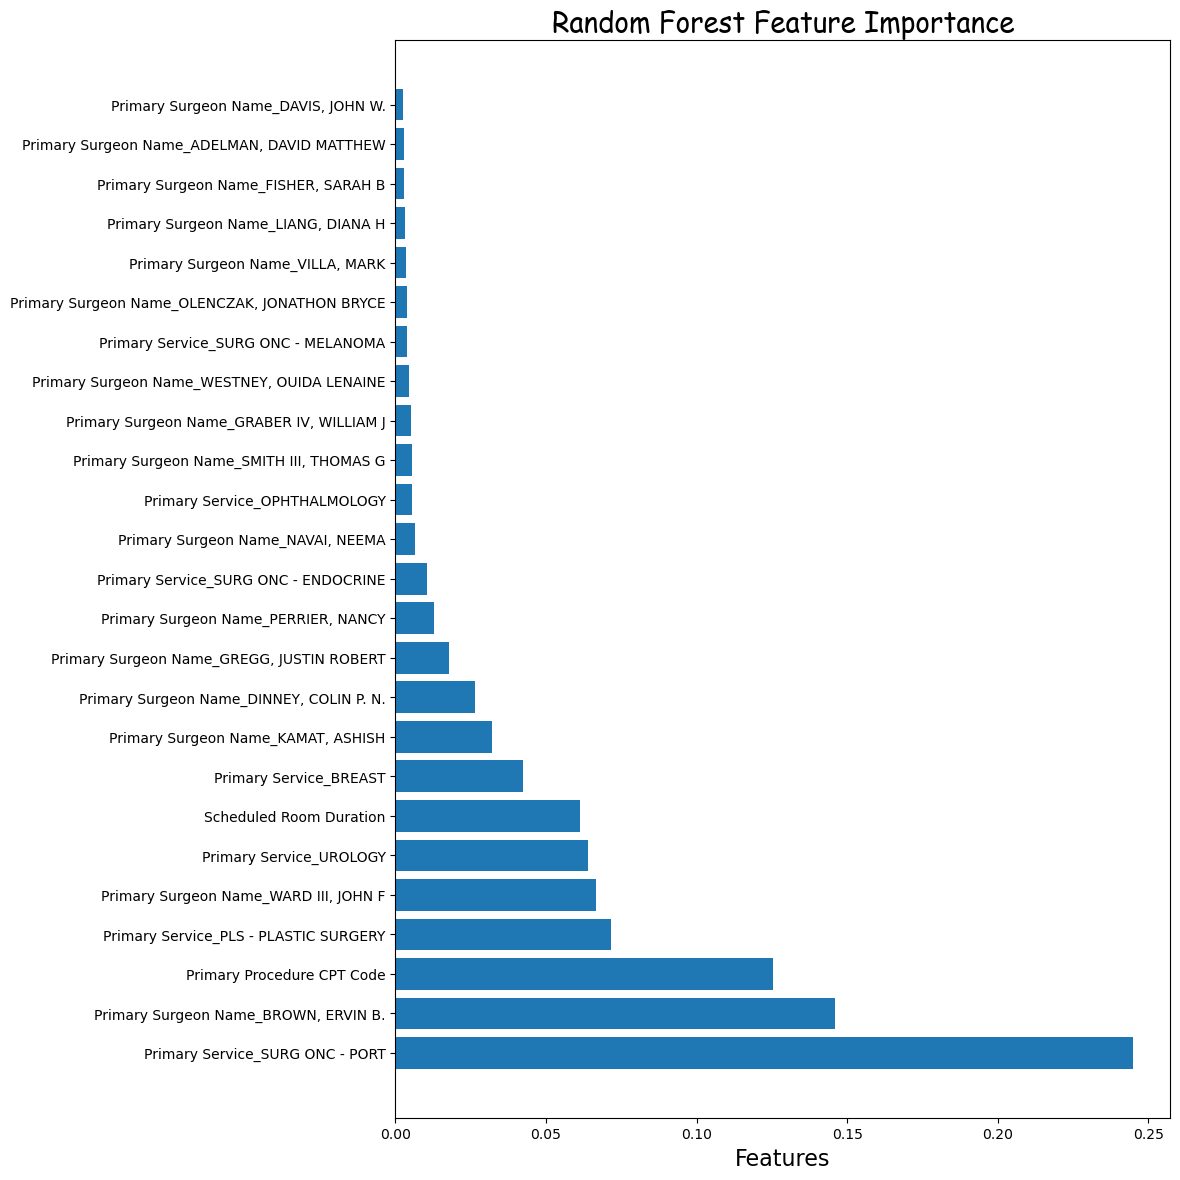

In [71]:
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()